# Last Hope and all Tasks

## Setup

In [1]:
#Für Colab
!git clone -b master https://github.com/HennFarr/Coins.git
!pip install keras_tuner
!pip install shap

Cloning into 'Coins'...
remote: Enumerating objects: 12198, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 12198 (delta 63), reused 152 (delta 61), pack-reused 12044
Receiving objects: 100% (12198/12198), 1.02 GiB | 37.89 MiB/s, done.
Resolving deltas: 100% (395/395), done.
Checking out files: 100% (21060/21060), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 32.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 27.1 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras


from keras import layers
import keras_tuner as kt
from keras.preprocessing.image import ImageDataGenerator, img_to_array,load_img
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import shap
import cv2


### Local or Google Colab 

In [3]:
local_data_dir="new_extended_dataset/original"
colab_data_dir="/content/Coins/new_extended_dataset/original"

### Data

#### Clear Data

In [4]:
num_skipped = 0
for folder_name in ("1c", "1e", "2c", "2e", "5c", "10c", "20c","50c"):
    folder_path = os.path.join(colab_data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


#### Get Data

In [5]:
batch_size=64   
target_size = 200

In [6]:
# Training split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    colab_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=["1c", "2c", "5c", "10c", "20c", "50c", "1e", "2e"],
    validation_split=0.25,
    subset="training",
    seed=42,
    image_size=(target_size,target_size),
    batch_size=batch_size,
)

Found 9664 files belonging to 8 classes.
Using 7248 files for training.


In [7]:
# Validation split
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    colab_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=["1c", "2c", "5c", "10c", "20c", "50c", "1e", "2e"],
    validation_split=0.25,
    subset="validation",
    seed=42,
    image_size=(target_size,target_size),
    batch_size=batch_size,
)

Found 9664 files belonging to 8 classes.
Using 2416 files for validation.


In [8]:
# Test split
# 38 Batches/2
test_ds = val_ds.take(19)
val_ds = val_ds.skip(19)

## Visualisierung 

In [9]:
class_names = train_ds.class_names

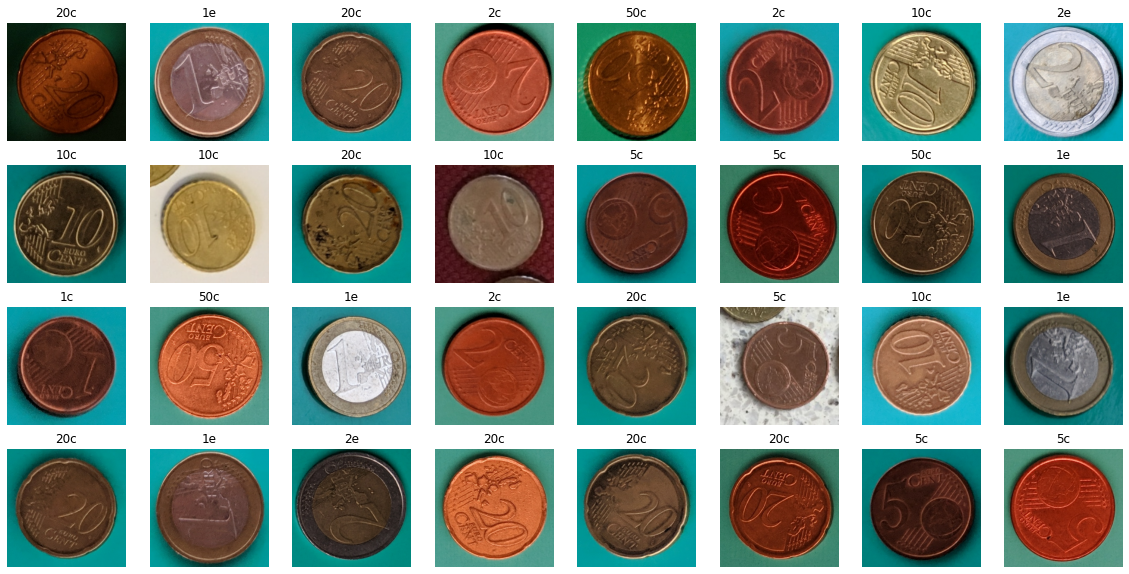

In [10]:
# First 32 images + label of the first TRAINING batch
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
  x_train=images    #For later
  y_train=labels    #For later
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

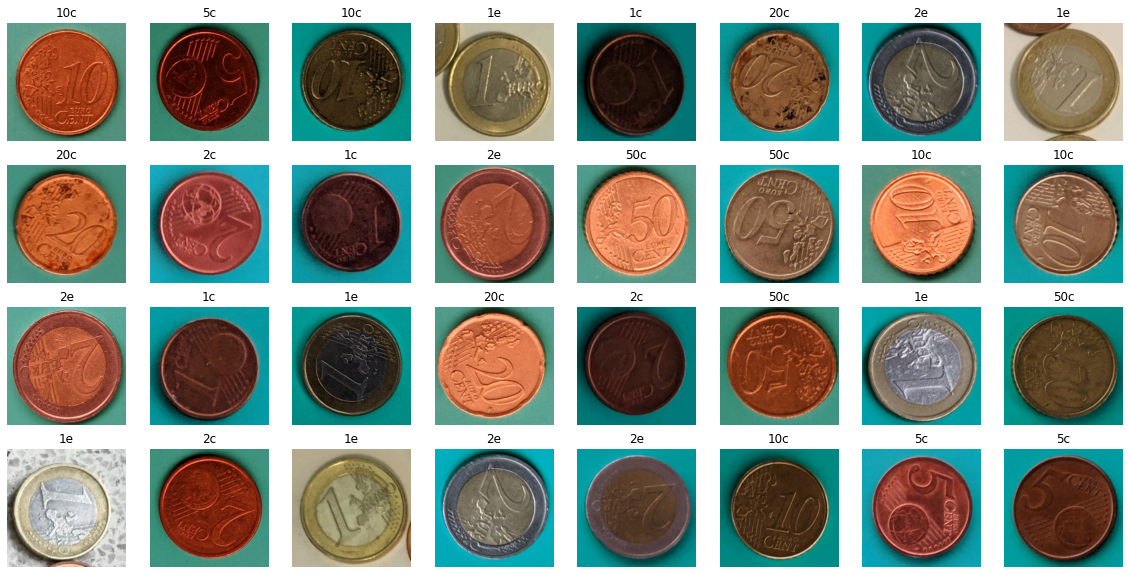

In [11]:
# First 32 images + label of the first VALIDATION batch
plt.figure(figsize=(20, 10))
for images, labels in val_ds.take(1):
  x_val=images   #For later
  y_val=labels   #For later
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

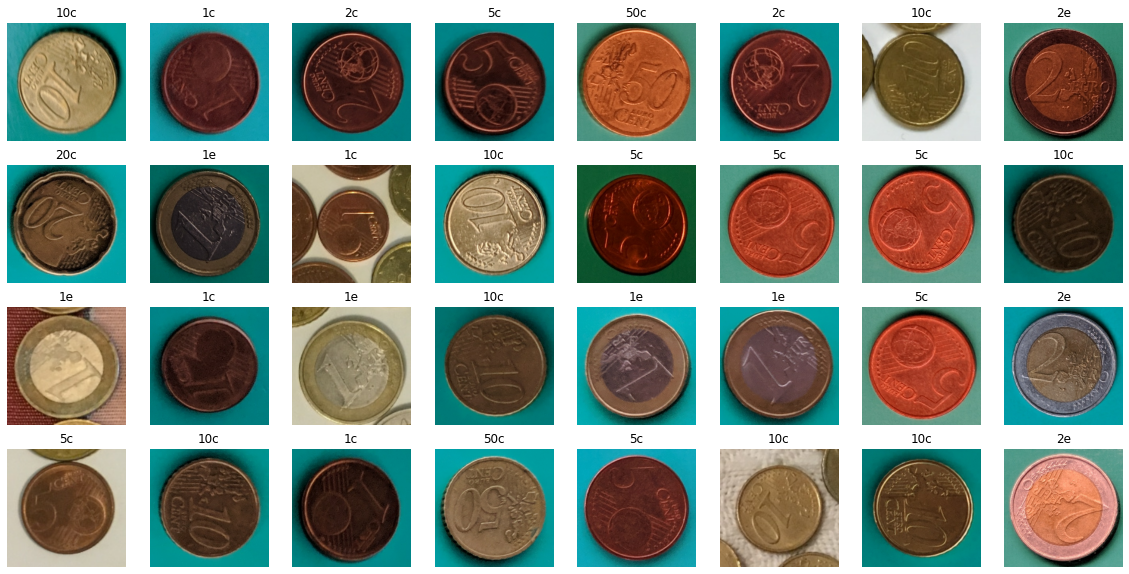

In [12]:
# First 32 images + label of the first TEST batch
plt.figure(figsize=(20, 10))
for images, labels in test_ds.take(1):
  x_test=images   #For later
  y_test=labels   #For later
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model Building

In [13]:
train_ds = train_ds.prefetch(buffer_size=64)
val_ds = val_ds.prefetch(buffer_size=64)

### Data Augmentation 

In [14]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(factor=0.5),
])

### Model & Layers
>specific comments missing
### Compiling
- 'categorical_crossentropy' works on one-hot encoded label
- 'sparse_categorical_crossentropy' works on integer label


In [15]:
def build_model(hp):
    inputs = keras.Input(shape=(target_size,target_size, 3))

    x = data_augmentation(inputs)

    x = layers.Rescaling(1.0 / 255)(x)

    x = layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    for n_filters in [64, 128, 256, 512]:
        x = layers.Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(n_filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual


    x = layers.Conv2D(filters=728, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.SpatialDropout2D(0.5)(x)
    
    #GAP2DvsFlatten
    if hp.Boolean("GAPvsFlatten"):
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.Flatten()(x)

    outputs = layers.Dense(8, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    #Compile 
    model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

    return model
    #model.summary()

In [16]:
build_model(kt.HyperParameters())

In [17]:
#keras.utils.plot_model(model, show_shapes=True)

### Callback
- Saving best Model 
- Early Stopping not suitable (s. history below)

In [18]:
local_model_dir = "Models/Tuned/tuned_model"
colab_model_dir = "/content/Coins/Models/Tuned/tuned_model"

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(colab_model_dir, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.01, patience=6)
]

## Model Tuning / Training
>Needs to be done in Google Colab

In [20]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=2,               #Only True or False
    executions_per_trial=1,     #Saving Time
    overwrite=True,
    directory="/content/Coins/Models/Tuned/search",
    project_name="Coin Classification",
)

tuner.search_space_summary()

Search space summary
Default search space size: 1
GAPvsFlatten (Boolean)
{'default': False, 'conditions': []}


In [21]:
tuner.search(
    train_ds,
    epochs=50,
    validation_data=val_ds
)

Trial 2 Complete [00h 31m 35s]
val_accuracy: 0.9599999785423279

Best val_accuracy So Far: 0.9950000047683716
Total elapsed time: 01h 04m 26s
INFO:tensorflow:Oracle triggered exit


In [22]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('GAPvsFlatten'))
model = tuner.hypermodel.build(best_hps)
model.summary()

True
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 200, 200, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 200, 200, 3)  0           ['sequential[4][0]']             
                                                                                                  
 conv2d_15 (Conv2D)             (None, 100, 100, 16  448         ['rescaling_1[0][0]'] 

In [23]:
history = model.fit(
    train_ds, 
    epochs=35, 
    callbacks=callbacks, 
    validation_data=val_ds,
)

Epoch 1/50
114/114 [==============================] - 41s 336ms/step - loss: 1.3555 - accuracy: 0.5164 - val_loss: 8.5821 - val_accuracy: 0.1117
Epoch 2/50
114/114 [==============================] - 39s 335ms/step - loss: 0.9510 - accuracy: 0.6054 - val_loss: 4.5634 - val_accuracy: 0.1425
Epoch 3/50
114/114 [==============================] - 33s 287ms/step - loss: 0.8028 - accuracy: 0.6679 - val_loss: 8.2335 - val_accuracy: 0.1275
Epoch 4/50
114/114 [==============================] - 39s 339ms/step - loss: 0.7163 - accuracy: 0.7064 - val_loss: 1.2730 - val_accuracy: 0.5242
Epoch 5/50
114/114 [==============================] - 38s 331ms/step - loss: 0.6055 - accuracy: 0.7602 - val_loss: 0.9843 - val_accuracy: 0.6317
Epoch 6/50
114/114 [==============================] - 39s 337ms/step - loss: 0.5446 - accuracy: 0.7875 - val_loss: 0.8072 - val_accuracy: 0.7158
Epoch 7/50
114/114 [==============================] - 39s 334ms/step - loss: 0.4333 - accuracy: 0.8362 - val_loss: 0.6419 - val_ac

### Training history

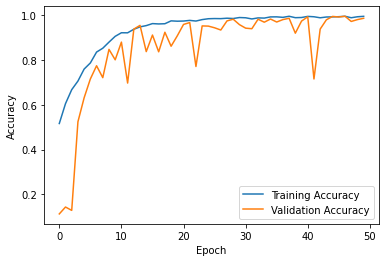

In [24]:
epochs_range = range(50)

plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Loading Model
> Loading Model in local environment for later evaluation

In [25]:
model_loaded = keras.models.load_model(colab_model_dir)

In [26]:
test_loss, test_acc = model_loaded.evaluate(test_ds)

19/19 [==============================] - 4s 145ms/step - loss: 0.0120 - accuracy: 0.9959


## Model Evaluation

### Test Split

In [27]:
predictions = model_loaded.predict(x_test)
#Rescaling 
x_test_r = x_test / 255

In [28]:
#Function by Kirenz
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

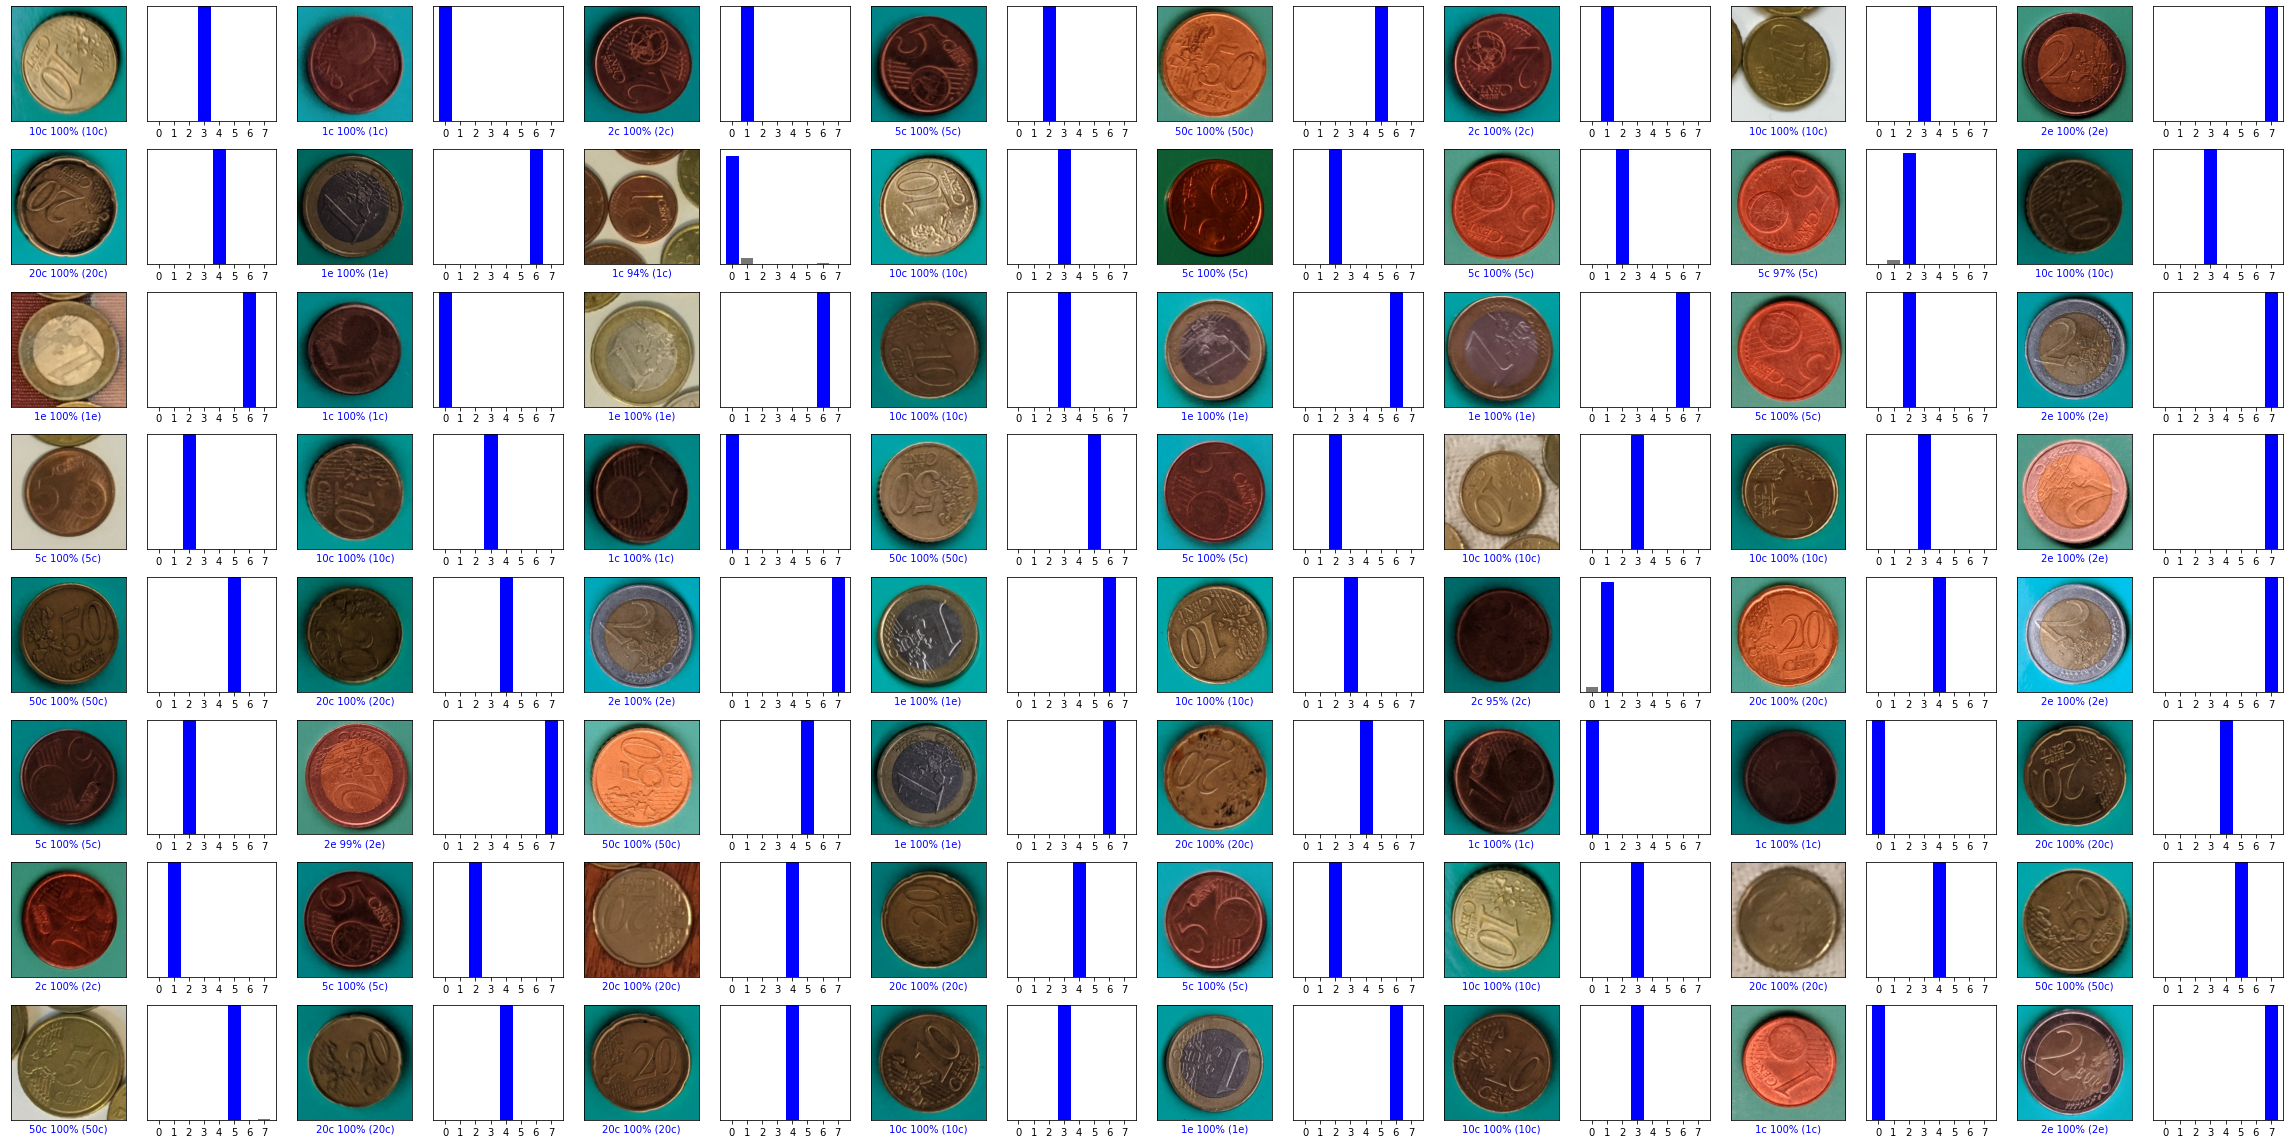

In [29]:
#Plot of the first Batch of test_ds
num_rows = 8
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test_r)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

### Real Test Images

In [32]:
local_t_data = "real_test_data/one"
colab_t_data = "/content/Coins/real_test_data/one"

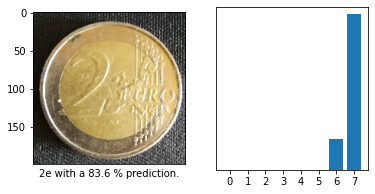

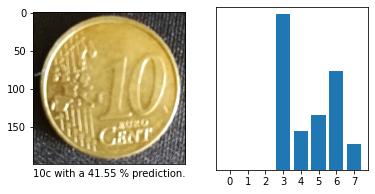

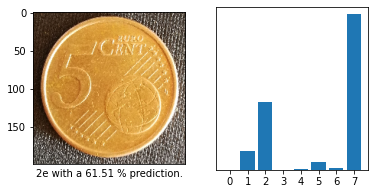

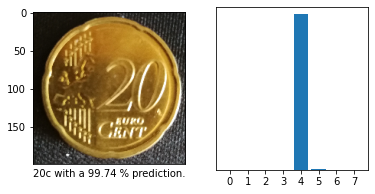

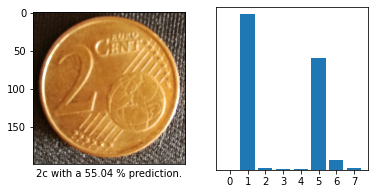

In [33]:
for i in range(1,6):
    #Load and prediction
    img = load_img(colab_t_data+"/"+str(i)+".jpg", target_size=(200, 200))
    x = img_to_array(img)                           
    x = x.reshape((1,) + x.shape)
    s_prediction = model_loaded.predict(x)
    #Darstellung
    plt.figure(figsize=(6,3))
    
    plt.subplot(1,2,1)  
    plt.imshow(img)
    plt.xticks([])
    plt.xlabel(f"{class_names[np.argmax(s_prediction)]} with a { (100 * np.max(s_prediction)).round(2) } % accuracy.")
    
    plt.subplot(1,2,2)
    plt.xticks(range(8))
    plt.yticks([])
    plt.bar(range(8),s_prediction[0])

    plt.show()

#class_names=["1c", "2c", "5c", "10c", "20c", "50c", "1e", "2e"]

## Explainable AI

In [36]:
img_path_colab='/content/Coins/big data set/original/2e/IMG_20190611_130947_0.jpg'
img_path_local='big data set/original/2e/IMG_20190611_130947_0.jpg'

### CNN Filters

conv2d_15 (None, 100, 100, 16)
16
Red


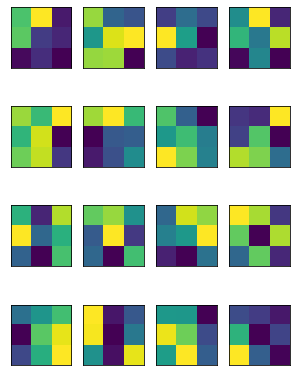

Green


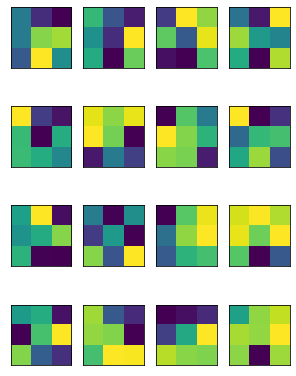

Blue


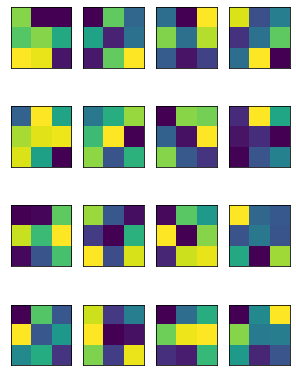

In [34]:
conv2_16 = model_loaded.layers[3]
weights, bias= conv2_16.get_weights()
print(conv2_16.name, conv2_16.output_shape)

f_min, f_max = weights.min(), weights.max()
filters = (weights - f_min) / (f_max - f_min)  
print(filters.shape[3])

n_filters=filters.shape[3]
columns=4
rows=4
RGB=["Red","Green","Blue"]
for c in range(3):
    fig=plt.figure(figsize=(5,7))
    print(RGB[c])
    for i in range(1, n_filters+1):
        f=filters[:,:,:, i-1]
        fig = plt.subplot(rows, columns, i)
        fig.set_xticks([])
        fig.set_yticks([])
        plt.imshow(f[:,:,c])    #RGB R:0
    plt.show()
    

### Feature Maps

conv2_16


invalid value encountered in true_divide


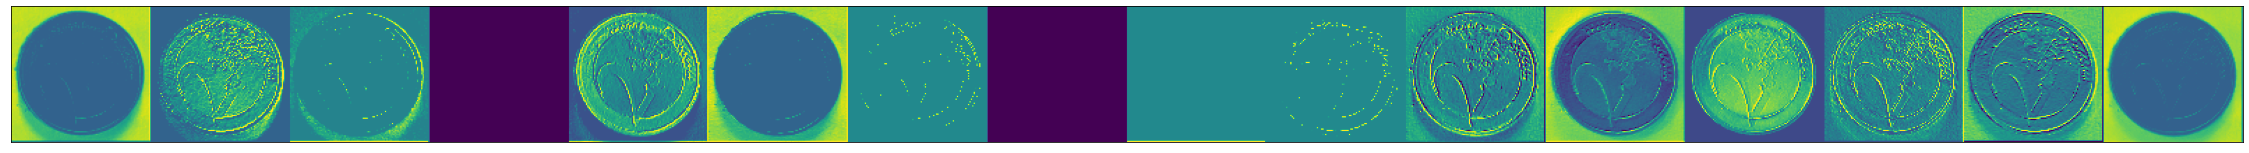

In [37]:
print("conv2_16")
output = model_loaded.layers[3].output
visualization_model = tf.keras.models.Model(inputs = model_loaded.input, outputs = output)

img = load_img(img_path_colab, target_size=(200, 200))
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)

feature_map = visualization_model.predict(x)

n_features = feature_map.shape[-1]  # number of features in the feature map
size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

display_grid = np.zeros((size, size * n_features))

for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()           # invalid value ??
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

scale = 40 / n_features
plt.figure(figsize=(scale * n_features, scale))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])
plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()

### SHAP

In [53]:
np_x_train = x_train.numpy()
np_x_val = x_val.numpy()
np_x_test = x_test.numpy()

In [54]:
np_x_train = np_x_train / 255.0
np_x_val = np_x_val / 255.0
np_x_test = np_x_test / 255.0

In [55]:
explainer = shap.GradientExplainer(model_loaded, np_x_train)

In [62]:
shap_values = explainer.shap_values(np_x_test[15:20])

In [63]:
print(len(shap_values))
print(len(shap_values[0]))

8
5


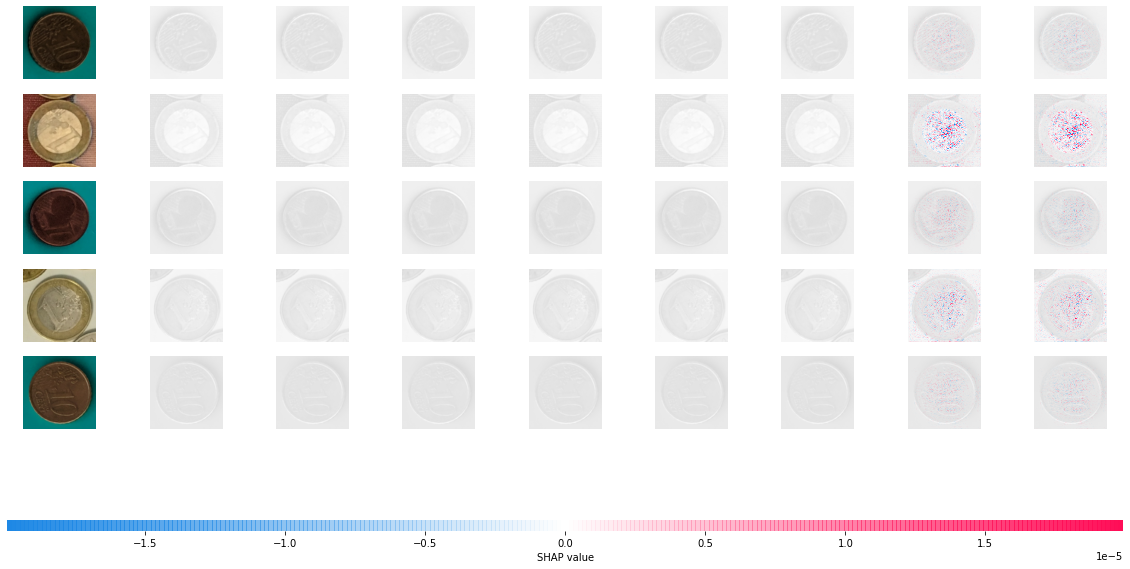

In [64]:
shap.image_plot([shap_values[i] for i in range(8)], np_x_test[15:20])

## Multiple Coins

In [ ]:
def loadImage(src):
    img = cv2.imread(src)
    if not img is None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
def findCoins(img, showCoins = False):
    scaling = 600.0/max(img.shape[0:2])
    #print (scaling)
    img_gray = cv2.resize(img, None, fx=scaling, fy=scaling)
    img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.blur(img_gray, (5,5))
    coins = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1.2, 30, param2 = 35, minRadius = 20, maxRadius = 50)
    coins = (np.round(coins[0,:]) / scaling).astype("int")
    return coins

In [ ]:
def adjust_gamma(image, gamma=1.0):

   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

In [ ]:
local_img="real_test_data/multi/IMG_20220620_105307.jpg"
colab_img="/content/Coins/real_test_data/multi/IMG_20220620_105307.jpg"

In [ ]:
img = loadImage(local_img)

In [ ]:
coins = findCoins(img, showCoins = True)

In [ ]:
maxRadius = np.amax(coins,0)[2]+10

class_names=["1c", "2c", "5c", "10c", "20c", "50c", "1e", "2e"]
n=int(len(coins)/2)
num_rows = n+2
num_cols = n-2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols,2*num_rows))

clone = img.copy()

for i,(x,y,r) in enumerate(coins):
    img_coin = img[y-maxRadius:y+maxRadius, x-maxRadius:x+maxRadius]
    if img_coin.shape[0]==0 or img_coin.shape[1]==0:
        continue

    img_coin = cv2.resize(img_coin, (200,200))
    img_x = adjust_gamma(img_coin, gamma=1)    #Gamma Experiment: Je nach Gamma-Wert Performed das Modell besser oder Schlechter. Stark vom Bild abhängig
    img_x = img_to_array(img_x)                    
    img_x = img_x.reshape((1,) + img_x.shape)

    s_prediction = model_loaded.predict(img_x)
    pred = f"{class_names[np.argmax(s_prediction)]} with { (100 * np.max(s_prediction)).round(2) } % acc"

    plt.subplot(num_rows,2*num_cols, 2*i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(pred)
    plt.imshow(img_coin)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.xticks(range(8))
    plt.yticks([])
    plt.bar(range(8),s_prediction[0])

    cv2.rectangle(clone, (x-maxRadius, y-maxRadius), (x+maxRadius, y+maxRadius),(0,100,0), 5)
    cv2.rectangle(clone,(x-maxRadius, y-maxRadius),(x+maxRadius-20,y-maxRadius-50),(0,100,0),-1)
    cv2.putText(clone, pred, (x-maxRadius, y-maxRadius-10),cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(30,20))
plt.xticks([])
plt.yticks([])
plt.imshow(clone)
plt.show()